# Forecasting Time Series with ARIMA Models<br>
Whitney Rueckl <br>
July 2022 <br>

---

*Reference: Mastering Python for Finance: Implement Advanced State-of-the-art Financial Statistical Applications Using Python, 2nd Edition by James Ma Weiming*

**Objective:** Objective of this analysis is to forecast the prices of financial securities using an ARIMA model. This involves assessing whether a time series is stationary, transforming it into a stationary process, and then forecasting future prices. <br>

**Contents:** <br>
[Get Historical Price Data](#the_data)


[Stationarity of Time Series for Statistical Modeling](#the_data)

> [Augmented Dickey-Fuller Test for Stationary Processes](#adf_test)

[Making Time Series Data Stationary](#make_staionary)

[Forecasting for Time Series Data (seasonal ARIMA model)](#forecasting)

In [1]:
import os
import sys
#sys.version

import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.max_rows = 10
#from datetime import datetime
import missingno as msno
import itertools

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


import matplotlib.pyplot as plt
import plotly.express as px

import quandl
quandl.ApiConfig.api_key = 'xZGXNnrkShEZDyaCwnCu'

C:\Users\whitn\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### User defined functions:

In [2]:
def runADFtest(df): 
    '''
     Run an ADF test
     
     Arguements: 
     df: a dataframe
     
     Returns: The test statistic, p-value, and critical values
     
     Note that the `adfuller()` method returns a tuple of seven values. 
     We're intresed in the test statistic, p-value, and critical values. 
     These are the first, second, and fifth values returned.
    
    '''
    result = adfuller(df)
    result
    print('ADF statistic: ',  result[0])
    print('p-value:', result[1])

    critical_values = result[4]
    for key, value in critical_values.items():
        print('Critical value (%s): %.3f' % (key, value))
        
    return result[0], result[1], result[4]

<a id='the_data'></a>
### Pull histoircal price data

Pulling **futures price data** from CME (using the Quandl API) <br>

Link to see quandl codes for commodities: https://blog.data.nasdaq.com/api-for-commodity-data

In [3]:
# The sixth column of the dataset contains the settlement prices.
ticker = 'CHRIS/CME_SI1'
df = quandl.get(
    ticker, 
    column_index=6,
    collapse='monthly',
    start_date='2000-01-01')
df

,Settle
Date,
2000-01-31,5.287
2000-02-29,5.048
2000-03-31,5.020
2000-04-30,4.960
2000-05-31,4.941
...,...
2021-02-28,26.440
2021-03-31,24.532
2021-04-30,25.853


In [4]:
# resample on a monthly basis and forward fill missing
df_settle = df['Settle'].resample('MS').ffill().dropna()
df_settle 

Date
2000-02-01     5.287
2000-03-01     5.048
2000-04-01     5.020
2000-05-01     4.960
2000-06-01     4.941
               ...  
2021-02-01    26.953
2021-03-01    26.440
2021-04-01    24.532
2021-05-01    25.853
2021-06-01    28.014
Freq: MS, Name: Settle, Length: 257, dtype: float64

Compute the rolling mean and standard deviation with a window period of one year:

In [5]:
df_rolling = df_settle.rolling(12)
df_mean = df_rolling.mean()
df_std = df_rolling.std()

In [6]:
#df_mean[df_mean.index < '2001-01-01']

---
## Stationarity of Time Series
---

### Importance of stationarity for statistical modeling:

Most statistical models for time series data require that the data be stationary. This is because most statistical models are built upon the assumption that mean and variance are consistent over time and that observations are independent. 

A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, are constant over time. **Note that in finance, the data rarely exhibits a stationary distribution over time**

> **Methods of checking whether time series is stationary or non stationary:**
> - Visualizations: plot a simple time series graph and look for obvious trends or seasonality.
> -  Statistical summaries: partition the data into time chunks and look for significant differences (compare the mean and variance of each group for example)
> - Statistical tests: statistical tests such as the *Augmented Dickey-Fuller Test* (test for a unit root) can be used to check if stationarity expectations have been met or violated.

### Visual inspection as a check for a stationary process: <br>
Plot the rolling average against the price series and then the rolling standard deviation

Text(0.5, 1.0, 'CHRIS/CME_SI1 Settlement Price vs Rolling Mean')

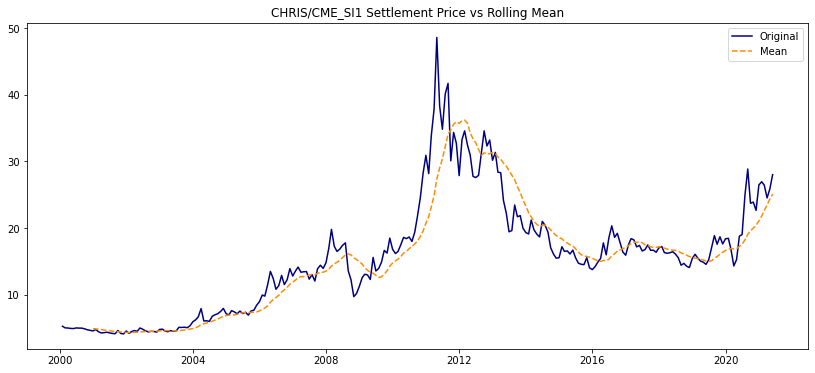

In [58]:
plt.figure(figsize=(14, 6))
plt.plot(df_settle, label='Original',  color = 'navy')
plt.plot(df_mean, label='Mean', linestyle = '--', color = 'darkorange')
plt.legend()
plt.title(str(ticker) + " Settlement Price vs Rolling Mean")

# using plotly express:
# fig = px.line(df_settle)
# fig2 = px.line(df_mean)
# fig.add_trace(fig2.data[0])

Text(0.5, 1.0, 'CHRIS/CME_SI1 Settlement Price Rolling Standard Deviation')

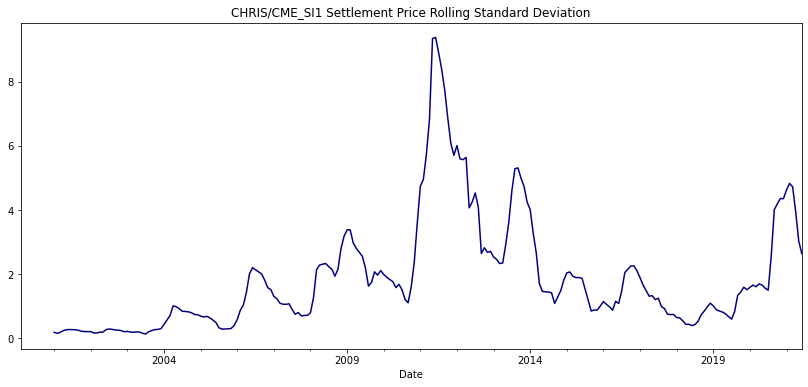

In [54]:
df_std.plot(color = 'navy', figsize=(14, 6))
plt.title(str(ticker) + " Settlement Price Rolling Standard Deviation")

> **...Well, that certainly doesn't look stationary to me...**

<a id='adf_test'></a>
### Testing for Stationary Data: Augmented Dickey-Fuller Test

**Augmented Dickey-Fuller Test:** Tests for a unit root in the time series data. Unit roots can cause unpredictable results in time series analysis. Values of the ADF test statistic are negative. Lower values of ADF indicates stronger rejection of the null hypothesis.

> **The test statistic:** the ADF test statistic is negative and the more negative/lower values indicates stronger rejection of the null hypothesis. <br>

> **Null hypothesis, H0:** "The data is non-stationary". If failed to reject H0, it suggests that the time series contains a unit root and is non-stationary <br>
> **Alternate hypothesis, H1:** "The data is stationary". If H0 is rejected, it suggests that the time series does not contain a unit root and is stationary
<br>

> **p-value > 0.05:** Fail to reject the null hypothesis H0 (conclude data has a unit root and is non-stationary) <br>
> **p-value ≤ 0.05:** We reject the null hypothesis H0 and (conclude data does not have a unit root and is stationary)
<br>

> **Note on critical values:**
> - The **critical values** at $\alpha$%, correspond to ($1-\alpha$)% confidence intervals. For example, if the ADF test statistics is lower than then the critical value at $\alpha = 5$%, that indicates a 95% confidence interval that the data is stationary !! double check this with stats book p.391 !!
> - The **critical region** is the subset of the sample space that corresponds to rejecting the null hypothesis *(see Chapter 12 of Bain/Engelhardt textbook)*

In [38]:
#help(adfuller)

#### Perform ADF test:

In [28]:
adf_result = runADFtest(df_settle)

ADF statistic:  -1.6203827309749637
p-value: 0.4725286523449874
Critical value (1%): -3.457
Critical value (5%): -2.873
Critical value (10%): -2.573


Interpreting the ADF test results: The p-value is > 0.05. Additionally, the ADF test statistic is greater than all critical values. We cannot reject the null hypothesis and conclude the data is non-stationary. (The null hypothesis is that the data is non-stationary). <br>

## Making a time series stationary

<a id='make_staionary'></a>
Non-stationary time series data is often a result of **trend or seasonality**. Making a time series data stationary means we remove the trend and seasonality effects, and therefore make it suitable for statistical forecasting.<br>
- A time series with a trend has a mean that is not constant over time. <br>
- A time series with seasonality has a reoccuring patterns or variations at specific intervals in time.

**Methods of removing trends and/or seasonality:** <br>
- **Detrending:** This involves a transformation step that normalizes large values into smaller ones. Examples could be a logarithmic function, a square root function, or even a cube root. A further step is to subtract the transformation from the moving average.
<br>
<br>
- **Differencing:** Differencing involves the difference of time series values with a time lag. The first-order difference of the time series is given by the following formula: $$\Delta y_{t}=\log \left(y_{t}\right)-\log \left(y_{t-1}\right)
$$
<br>
<br>
- **Decomposition:** Decomposing involves modeling both the trend and seasonality, and then removing them.

### Detrending

Below performs detrending using a logarithmic transformation and subtracting from the moving average of two periods (a common transformation).

In [29]:
# log transfomation:
df_log = np.log(df_settle)

# calculate rolling statistics
df_log_ma = df_log.rolling(2).mean()
df_detrend = df_log - df_log_ma
df_detrend.dropna(inplace=True)

In [30]:
# # Mean and standard deviation of detrended data
df_detrend_rolling = df_detrend.rolling(12)
df_detrend_ma = df_detrend_rolling.mean()
df_detrend_std = df_detrend_rolling.std()

Text(0.5, 1.0, 'Detrended Data')

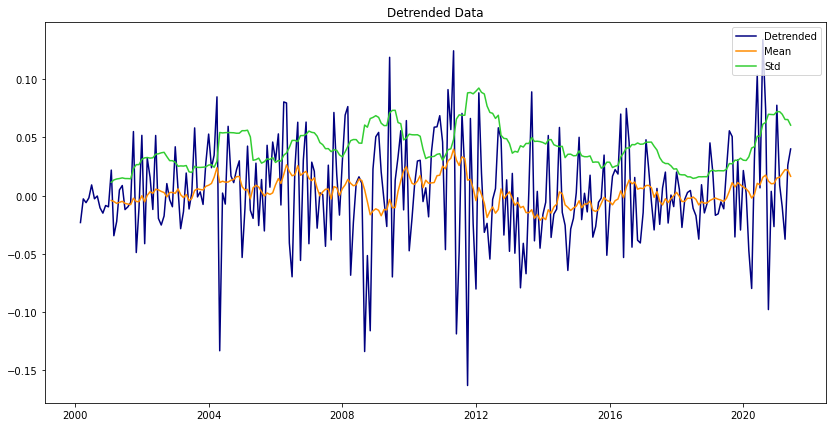

In [57]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(df_detrend, label='Detrended', color = 'navy')
plt.plot(df_detrend_ma, label='Mean', color = 'darkorange')
plt.plot(df_detrend_std, label='Std', color = 'limegreen')
plt.legend(loc='upper right');
plt.title("Detrended Data")

#### Perform ADF test

In [54]:
adf_result = runADFtest(df_detrend)
adf_result

ADF statistic:  -16.640057010319644
p-value: 1.637618993016105e-29
Critical value (1%): -3.456
Critical value (5%): -2.873
Critical value (10%): -2.573


(-16.640057010319644,
 1.637618993016105e-29,
 {'1%': -3.4562572510874396,
  '5%': -2.8729420379793598,
  '10%': -2.5728461399461744})

ADF Test Results for differenced data: The p-value for the detrended data is less than 0.05 and the ADF test statistic is lower than all the critical values. We can reject the null hypothesis and say that this data is stationary.

### Differencing to remove trend

In [61]:
# Reuse our log transformed data from the detrending section and shift by 3 periods to calculate difference
df_log_diff = df_log.diff(periods=3).dropna()

# Mean and standard deviation of differenced data
df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

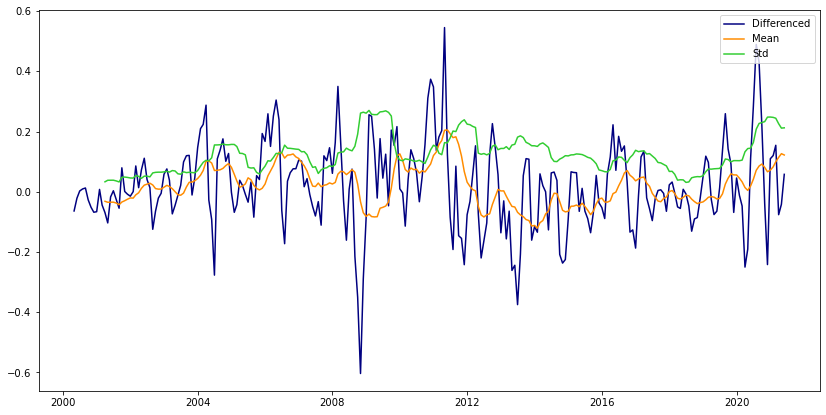

In [65]:
plt.figure(figsize=(14, 7))
plt.plot(df_log_diff, label='Differenced', color = 'navy')
plt.plot(df_diff_ma, label='Mean',  color = 'darkorange')
plt.plot(df_diff_std, label='Std', color = 'limegreen')
plt.legend(loc='upper right');

In [69]:
runADFtest(df_log_diff)

ADF statistic:  -3.726472401636718
p-value: 0.003755834627240809
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


(-3.726472401636718,
 0.003755834627240809,
 {'1%': -3.4577787098622674,
  '5%': -2.873608704758507,
  '10%': -2.573201765981991})

ADF Test Results for differenced data: The p-value is less than 0.05 and the test statistic is lower than the 5% critical value, indicating a 95% confidence level that this data is stationary. We can reject the null hypothesis and say that this data is stationary.

### Seasonal Decomposing

Using the same log transformed data `df_log` and the `seasonal_decompose()` method from the `statsmodels.tsa.seasonal` module. 
The `seasonal_decompose()` will model the time series dataset using moving averages and remove its trend and seasonality. <br>
https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html.

In [70]:
decompose_result = seasonal_decompose(df_log.dropna(), extrapolate_trend='freq')

df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid

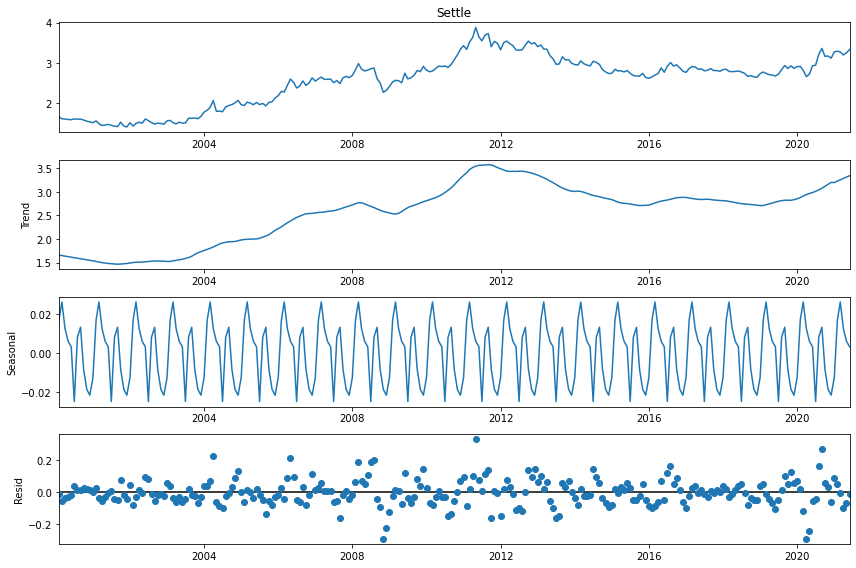

In [76]:
plt.rcParams['figure.figsize'] = (12, 8)
fig = decompose_result.plot()

Above we can see the individual trend and seasonality components being removed from the dataset and plotted, and the residuals plotted at the bottom. <br>

Visualize the statistical properties of the **residuals:**

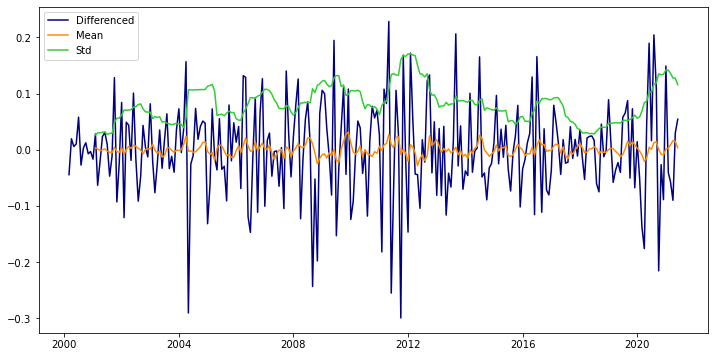

In [79]:
df_log_diff = df_residual.diff().dropna()

# Mean and standard deviation of differenced data
df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

# Plot the stationary data
plt.figure(figsize=(12, 6))
plt.plot(df_log_diff, label='Differenced', color = 'navy')
plt.plot(df_diff_ma, label='Mean', color = 'darkorange')
plt.plot(df_diff_std, label='Std', color = 'limegreen')
plt.legend()

In [80]:
runADFtest(df_log_diff)

ADF statistic:  -7.623576909918169
p-value: 2.0971546305308917e-11
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


(-7.623576909918169,
 2.0971546305308917e-11,
 {'1%': -3.458010773719797,
  '5%': -2.8737103617125186,
  '10%': -2.5732559963936206})

The p-value for the *residulas* of the decomposed data is less than 0.05. Our ADF test statistic is lower than all the critical values. We can reject the null hypothesis and say that this data is stationary.

#### Drawbacks of the ADF Test: 
https://rtmath.net/assets/docs/finmath/html/93a7b7b9-e3c3-4f19-8a57-49c3938d607d.htm#:~:text=There%20are%20some%20drawbacks%20of,%CE%B3%20is%20close%20to%20zero).

---
<a id='forecasting'></a>
# Forecasting & Predicting Times Series 
---

With stationary data, we can proceed to perform statistical modeling such as prediction and forecasting. <br>

- [ARIMA Model Overview](#arima_overview)
- [Grid Search for Optimal Model Parameters](#gridsearch_params)
- [Fitting a Seasonal ARIMA (SARIMA)](#fit_SARIMA)
- [Notes on SARIMA models](#about_SARIMA)

<a id='arima_overview'></a>
## Autoregressive Integrated Moving Average (ARIMA) Model <br>

- Autoregression (AR): A model that uses the dependency between an observation and its lagged values
- Integrated (I): The use of differencing an observation with an observation from a previous time stamp in making the time series stationary
- Moving average (MA): A model that uses the dependency between an observed error term and a combination of previous error terms, et

> - ARIMA(p,0,0): First-order autoregressive model, notated by AR(p). p is the lag order, indicating the number of lagged observations in the model. For example, ARIMA(2,0,0) is AR(2) and represented as follows: <br>
$$Y_{t}=c+\phi y_{t-1}+\phi y_{t-2}+e_{t}$$
> - ARIMA(0,d,0): First degree of differencing in the integrated component, also known as random walk, notated by I(d). d is the degree of differencing, indicating the number of times the data have had past values subtracted. For example, ARIMA(0,1,0) is I(1) and represented as follows: <br>
$$Y_{t}=Y_{t-1}+u$$
> - ARIMA(0,0,q): Moving average component, notated by MA(q). The order q determines the number of terms to be included in the model: <br>
$$Y_{t}=c+\phi_{1} e_{t-1}+\phi_{2} e_{t-2}+\ldots+\phi_{q} e_{t-q}+e_{t}$$

#### Given that the prices in the dataset exhibits seasonality, a *seasonal ARIMA* model is appropriate (the `SARIMAX()` function from `statsmodels`.

#### Lag plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

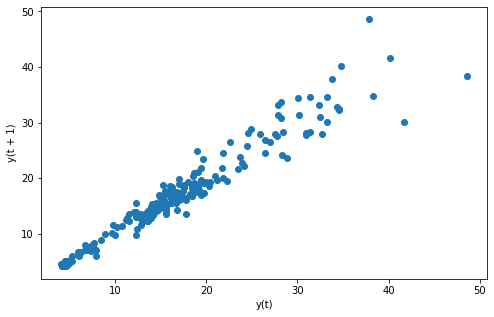

In [62]:
# https://pandas.pydata.org/pandas-docs/version/0.18.1/visualization.html#lag-plot
from pandas.plotting import lag_plot,  autocorrelation_plot
plt.figure(figsize=(8, 5))
lag_plot(df_settle)

#### Autocorrelation
https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm#:~:text=Autocorrelation%20plots%20

Notes on autocorrelation plots:
- Autocorrelation coefficient (x-axis)
$$R_{h}=C_{h} / C_{0}$$
where $\boldsymbol{C}_{\boldsymbol{h}}$ is the autocovariance function
$$C_{h}=\frac{1}{N} \sum_{t=1}^{N-h}\left(Y_{t}-\bar{Y}\right)\left(Y_{t+h}-\bar{Y}\right)$$
and $\boldsymbol{C}_{0}$ is the variance function
$$C_{0}=\frac{\sum_{t=1}^{N}\left(Y_{t}-\bar{Y}\right)^{2}}{N}$$
<br>

- Confidence interval bands (95% and 99% CI)
$$\pm z_{1-\alpha / 2} \sqrt{\frac{1}{N}\left(1+2 \sum_{i=1}^{k} y_{i}^{2}\right)}$$

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

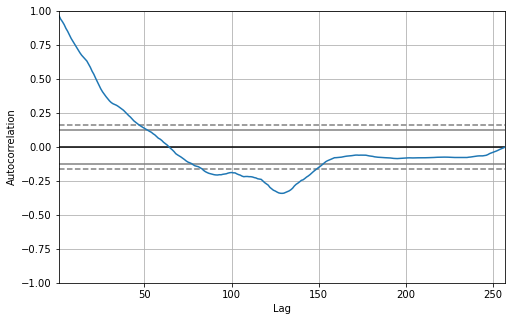

In [63]:
# autocorrelation plot (plot of autocorrelation coefficient on a lag)
# https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm#:~:text=Autocorrelation%20plots%20(Box%20and%20Jenkins,and%20all%20time%2Dlag%20separations.
plt.figure(figsize=(8, 5))
autocorrelation_plot(df_settle)

# alternative autocorr plot:
# from statsmodels.graphics.tsaplots import plot_acf
# plt.figure(figsize=(8, 5))
# plot_acf(df_settle, alpha = .01)
# plt.show()

<a id='gridsearch_params'></a>
### Parameter Tuning: find optimial combination of parameters for SARIMA model (grid search)

In [64]:
# Grid search function to find best combination of model parameters
def arima_grid_search(df, s):
    
    '''
    Four parameters are provided to the `SARIMAX()` function:
        1. The `seasonal_order` parameter, which is the ARIMA(p,d,q,s) seasonal component, where s is the number of periods in a season of the dataset. Since we are using monthly data, we use 12 periods to define a seasonal pattern. 
        2. The `enforce_stationarity=False` parameter doesn't transform the AR parameters to enforce stationarity in the AR component of the model. 
        3. The `enforce_invertibility=False` parameter doesn't transform MA parameters to enforce invertibility in the MA component of the model.
        4. The `disp=False` parameter suppresses output information when fitting our models.
        
    '''
        
        df_fit = df
        p = d = q = range(2)
        param_combinations = list(itertools.product(p, d, q))
        lowest_aic, pdq, pdqs = None, None, None
        total_iterations = 0
        for order in param_combinations:    
            for (p, q, d) in param_combinations:
                seasonal_order = (p, q, d, s)
                total_iterations += 1
                try:
                    model = SARIMAX(df_fit, order=order, 
                        seasonal_order=seasonal_order, 
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        disp=False
                    )
                    model_result = model.fit(maxiter=200, disp=False)

                    if not lowest_aic or model_result.aic < lowest_aic:
                        lowest_aic = model_result.aic
                        pdq, pdqs = order, seasonal_order

                except Exception as ex:
                    continue

        return lowest_aic, pdq, pdqs 

    

In [65]:
lowest_aic, order, seasonal_order = arima_grid_search(df_settle, 12)

C:\Users\whitn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [66]:
print('ARIMA{}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA(0, 1, 1)x(0, 1, 1, 12)
Lowest AIC: 1012.438


According to the grid search results, the `ARMIA(0, 1, 1, 12)` seasonal component model will yield the lowest AIC value. 

<a id='fit_SARIMA'></a>
## Fitting the Seasonal ARIMA Model

In [67]:
#Fit the SARIMAX model
model = SARIMAX(
       df_settle,
       order=order,
       seasonal_order=seasonal_order,
       enforce_stationarity=False,
       enforce_invertibility=False,
       disp=False
   )

model_results = model.fit(maxiter=200, disp=False)

In [68]:
# View stats info on the model
print(model_results.summary())
summary_stats = model_results.summary()

                                     SARIMAX Results                                      
Dep. Variable:                             Settle   No. Observations:                  257
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -503.219
Date:                            Thu, 25 Aug 2022   AIC                           1012.438
Time:                                    09:20:02   BIC                           1022.752
Sample:                                02-01-2000   HQIC                          1016.598
                                     - 06-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1312      0.030     -4.369      0.000      -0.190      -0.072
ma.S.L12      -1.0000    428.639   

Run model diagnostics to validate that model assumptions have not been violated. Using the `plot_diagnostics` function from `statsmodels`. 

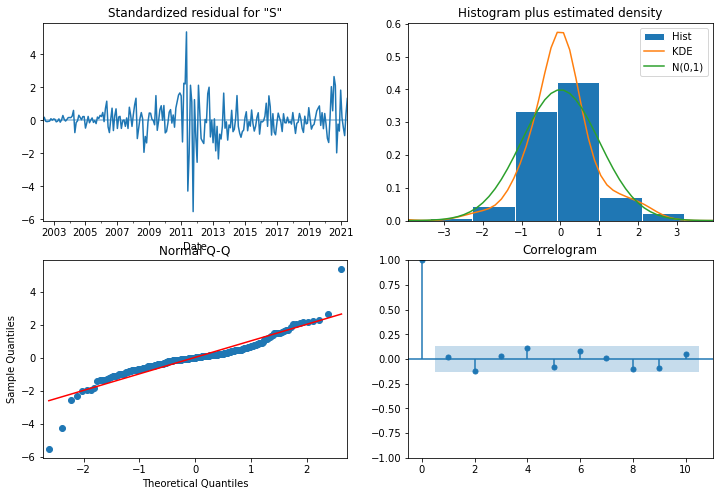

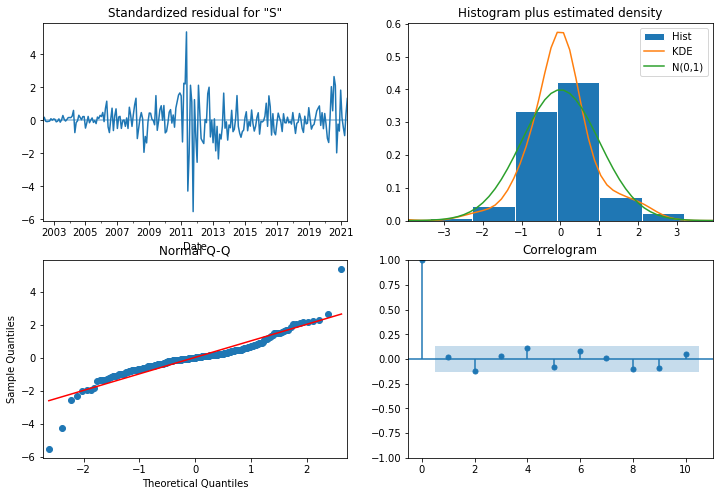

In [69]:
model_results.plot_diagnostics(figsize=(12, 8))

The top-right plot visualizes some density related information. It shows a histogram plus estimated density of standardized residuals of our current model, along with a Normal(0,1) density plotted for reference. Looking specifically at the kernel density estimate (KDE) of the standardized residuals (orange line), it suggests the errors are Gaussian with a mean close to zero. <br>
Let's see a more accurate statistic of the residuals. Notice the non-zero mean which suggests that the prediction is biased positively. <br>

In [70]:
model_results.resid.describe()

count    257.000000
mean       0.029578
std        2.046412
min      -11.730119
25%       -0.765916
50%       -0.033769
75%        0.686270
max       11.360883
dtype: float64

In [71]:
type(model_results)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

## Predicting and forecasting the SARIMAX model

Perform an in-sample prediction of the most recent 5 years, then a out-of-sample foreast for the next 5 months. The `get_prediction()` function does this. 

In [72]:
n = len(df_settle.index)

# Predict and forecast
prediction = model_results.get_prediction(
       start=n-(12*5), 
       end=n+5
       )

# Get CI's of the prediction
prediction_ci = prediction.conf_int()
prediction_ci.head(5)

,lower Settle,upper Settle
2016-07-01,11.372787,19.576531
2016-08-01,14.500889,22.704633
2016-09-01,16.393010,24.596754
2016-10-01,14.270871,22.474615
2016-11-01,15.192961,23.396705


In [93]:
#help(model_results.conf_int())

In [73]:
type(prediction)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

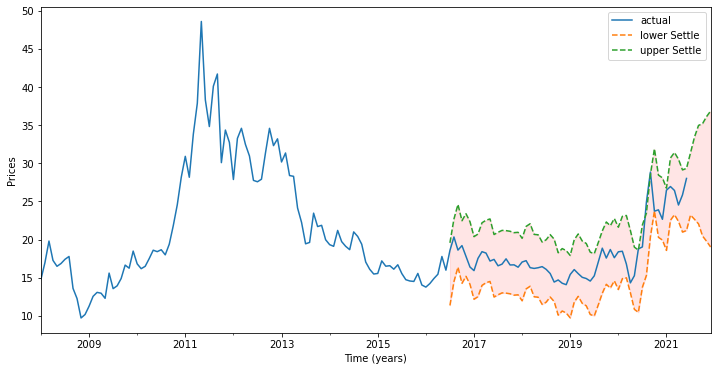

In [74]:
plt.figure(figsize=(12, 6))

ax = df_settle['2008':].plot(label='actual')
prediction_ci.plot(
    ax=ax, style=['--', '--'],
    label='predicted/forecasted')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci,
    color='r', alpha=.1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

# --- END ---

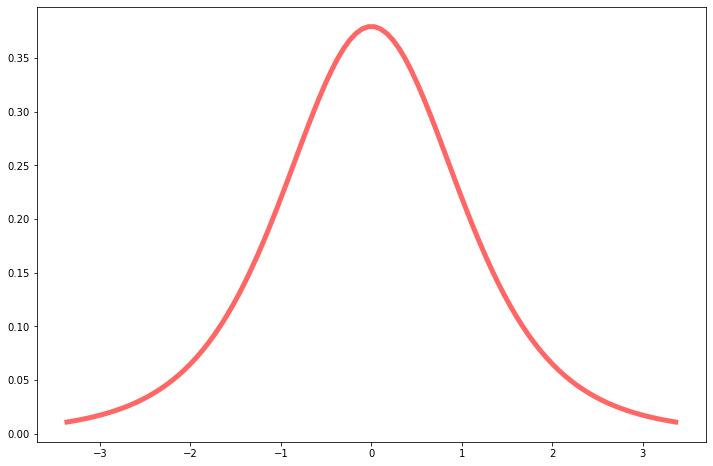

In [111]:
# Plot T-distribution
from scipy.stats import t 
#t.rvs(df=5, size =10)

df = 5
mean, var, skew, kurt = t.stats(df, moments='mvsk')

fig, ax = plt.subplots(1, 1)
x = np.linspace(t.ppf(0.01, df),
                t.ppf(0.99, df), 100)
ax.plot(x, t.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='t pdf')

inf

AttributeError: 't_gen' object has no attribute 't'

array([-7.93563787e-01, -7.82786352e-01,  6.19857382e+00,  1.53536370e-01,
        9.63232370e-01, -1.21404107e-04, -7.05793554e-01,  2.09873047e+00,
       -1.86276174e+00,  3.15011859e+00])

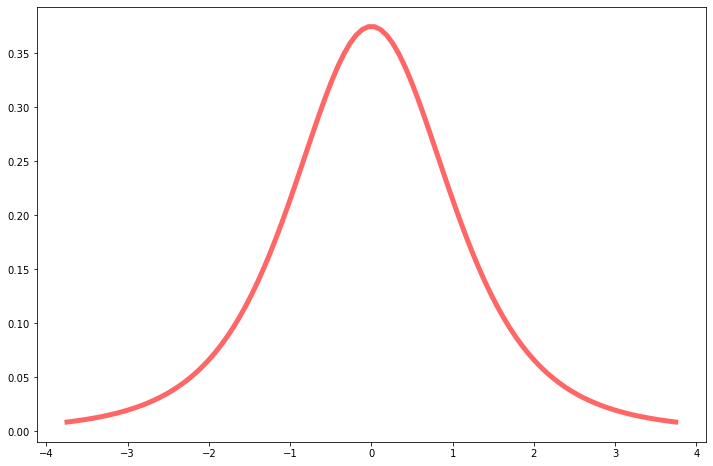

In [102]:
df = 4
mean, var, skew, kurt = t.stats(df, moments='mvsk')

fig, ax = plt.subplots(1, 1)

x = np.linspace(t.ppf(0.01, df),
                t.ppf(0.99, df), 100)
ax.plot(x, t.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='t pdf')

<a id='about_SARIMA'></a>
### Notes on SARIMA Models

Documentation on the statsmodels python library:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

Textbook referenced to build the `statsmodels.SARIMA()` class: <br>
*Durbin, James, and Siem Jan Koopman. 2012. Time Series Analysis by State Space Methods: Second Edition.*
https://radhakrishna.typepad.com/TimeSeries_Analysis_State_Space_Methods.pdf

The SARIMA model is specified $(p, d, q) \times(P, D, Q)_{s}$
$$
\phi_{p}(L) \tilde{\phi}_{P}\left(L^{s}\right) \Delta^{d} \Delta_{s}^{D} y_{t}=A(t)+\theta_{q}(L) \tilde{\theta}_{Q}\left(L^{s}\right) \zeta_{t}
$$

In [ ]:
# An alternate way to grid search for ARIMA:
# https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

# def evaluate_arima_model(X, arima_order):
#     # prepare training dataset
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     # make predictions
#     predictions = list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit()
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
#     # calculate out of sample error
#     error = mean_squared_error(test, predictions)
#     return error


# import warnings
# warnings.filterwarnings("ignore")

# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     mse = evaluate_arima_model(dataset, order)
#                     if mse < best_score:
#                         best_score, best_cfg = mse, order
#                     print('ARIMA%s MSE=%.3f' % (order,mse))
#                 except:
#                     continue
#     print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))